Julia

Comenzaremos usando Julia y lo primero que haremos será importar los paquetes necesarios para que funcione el programa.

In [ ]:
import Pkg;
Pkg.add("DeconvOptim")
Pkg.add("TestImages")
Pkg.add("Colors")
Pkg.add("ImageIO")
Pkg.add("Noise")
Pkg.add("ImageShow")
Pkg.add("Images")
Pkg.add("FFTW")

Una vez importados los paquetes lo que hemos hecho ha sido coger una imagen de prueba, añadirla borrosidad y ruido y hacer la deconvolución en 2D sin regularizar.
Usaremos la misma PSF para el código en python y el mismo número de iteraciones.

  1.921590 seconds (1.27 M allocations: 381.019 MiB, 7.25% gc time, 56.80% compilation time)
  1.116465 seconds (5.83 k allocations: 172.576 MiB, 32.31% gc time)


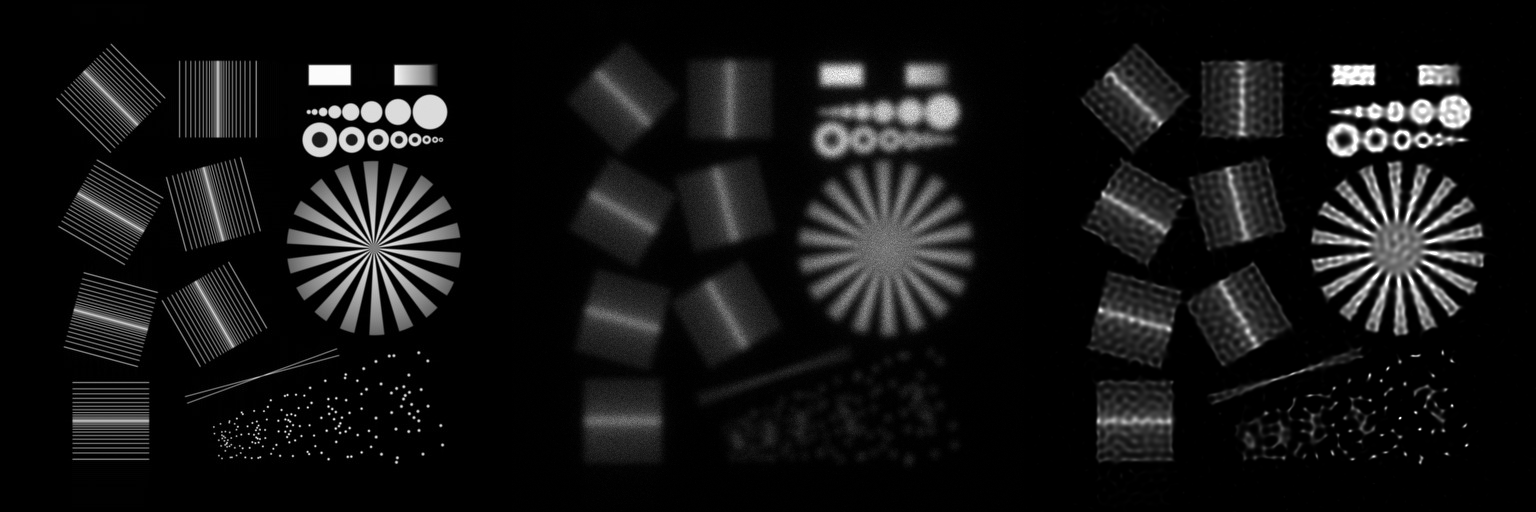

In [6]:
using DeconvOptim, TestImages, Colors, ImageIO, Noise, ImageShow, Images

# load test image
#img = Float32.(testimage("resolution_test_512"))
img = load("ImagenPrueba.jpg")
img = Float32.(img)
# generate simple Point Spread Function of aperture radius 30
psf = Float32.(generate_psf(size(img), 30))

# create a blurred, noisy version of that image
img_b = conv(img, psf) #blurred
img_n = poisson(img_b, 300) #blurred and noisy

# deconvolve 2D with default options
@time res, o = deconvolution(img_n, psf)

# deconvolve 2D with no regularizer
@time res_no_reg, o = deconvolution(img_n, psf, regularizer=nothing, iterations=30)

# show final results next to original and blurred version
Gray.([img img_n res_no_reg])

Python

In [ ]:
pip install numpy matplotlib scipy scikit-image imageio

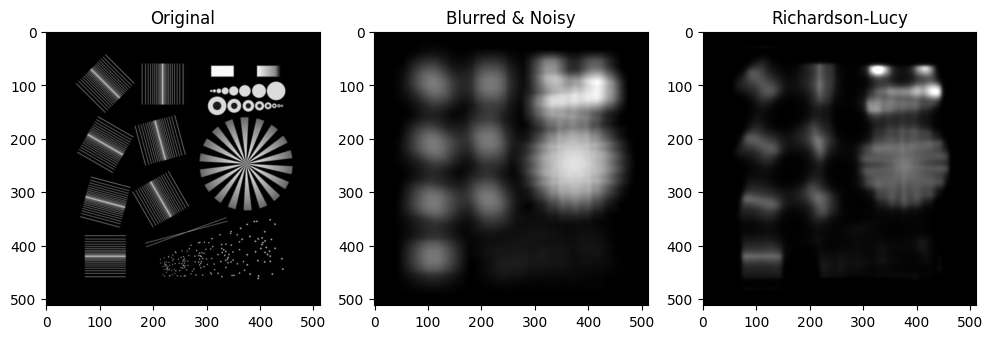

In [1]:
import numpy as np
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.metrics import peak_signal_noise_ratio
from skimage.restoration import richardson_lucy
import imageio.v2 as iio
from skimage.util import random_noise

# Load test image
img = img_as_float(iio.imread("ImagenPrueba.jpg"))

# Generate simple Point Spread Function of aperture radius 30
def generate_psf(shape, radius):
    y, x = np.mgrid[-radius:radius+1, -radius:radius+1]
    psf = np.exp(-(x**2 + y**2)/(2.0*radius**2))
    return psf / np.sum(psf)

psf = generate_psf(img.shape, 30)

# Create a blurred version of the image
img_b = convolve2d(img, psf, mode='same', boundary='wrap')

# Add noise to the blurred image

#img_n = np.random.poisson(img_b * 300) / 300.0
img_n = random_noise(img_b, mode='poisson', rng=np.random.default_rng(0))

# Deconvolve the image using Richardson-Lucy algorithm
res = richardson_lucy(img_n, psf, num_iter=30)

# Display original, blurred, and deconvolved images
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original')

plt.subplot(1, 3, 2)
plt.imshow(img_n, cmap='gray')
plt.title('Blurred & Noisy')

plt.subplot(1, 3, 3)
plt.imshow(res, cmap='gray')
plt.title('Richardson-Lucy')

plt.show()
